In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [73]:
transcripts = pd.read_csv('transcripts.csv', header = None)
transcripts.columns = ['id', 'text']
transcripts.head()

,id,text
0,p1,Interviewer: So how are you doing?|Interviewee...
1,p10,Interviewer: So how you doing?|Interviewee: G...
2,p11,Interviewer: So tell me about yourself. |Inte...
3,p12,Interviewer: So how are you doing today?|Inter...
4,p13,Interviewer: How are you doing today?|Intervie...


In [74]:
transcripts['text'] = transcripts['text'].str.replace(r'\br:', 'Interviewer:', regex=True)

In [75]:
pros_features = pd.read_csv('prosodic_features.csv')
pros_features.head(3)

,participant&question,duration,energy,min_pitch,max_pitch,mean_pitch,pitch_sd,pitch_abs,pitch_quant,pitchUvsVRatio,...,numVoiceBreaks,PercentBreaks,speakRate,numPause,maxDurPause,avgDurPause,TotDurPause:3,iInterval,MaxRising:3,MaxFalling:3
0,P1Q1,51.952125,0.015331,75.232657,396.635613,127.989222,27.821528,217.628692,119.690367,0.773830,...,136,0.42117,0.000342,55,1.290667,0.494,27.176,138,274.562,257.247
1,P1Q2,38.677312,0.015185,75.165527,397.613041,131.067490,26.452853,195.852246,124.820583,0.717333,...,97,0.38674,0.000444,40,1.866667,0.522,20.875,100,268.613,270.193
2,P1Q3,43.593896,0.014680,71.034761,395.930688,127.739086,26.006330,189.441737,120.457848,1.068376,...,112,0.43099,0.000475,44,2.624000,0.505,22.229,114,283.912,203.506


In [76]:
pros_features.columns

Index(['participant&question', 'duration', 'energy', 'min_pitch', 'max_pitch',
       'mean_pitch', 'pitch_sd', 'pitch_abs', 'pitch_quant', 'pitchUvsVRatio',
       'diffPitchMaxMin', 'diffPitchMaxMean', 'diffPitchMaxMode',
       'intensityMin', 'intensityMax', 'intensityMean', 'intensitySD',
       'intensityQuant', 'diffIntMaxMin', 'diffIntMaxMean', 'diffIntMaxMode',
       'avgVal1', 'avgBand2', 'avgBand3', 'jitter', 'shimmer',
       'numVoiceBreaks', 'PercentBreaks', 'speakRate', 'numPause',
       'maxDurPause', 'avgDurPause', 'TotDurPause:3', 'iInterval',
       'MaxRising:3', 'MaxFalling:3'],
      dtype='object')

In [77]:
scores_df = pd.read_csv('scores.csv')
scores_df.tail()

,Participant,Overall,Excited
133,pp83,6.045748,5.806617
134,pp84,5.710073,5.307262
135,pp85,5.626074,5.584830
136,pp86,4.853881,5.137644
137,pp89,4.960084,4.407999


<Axes: >

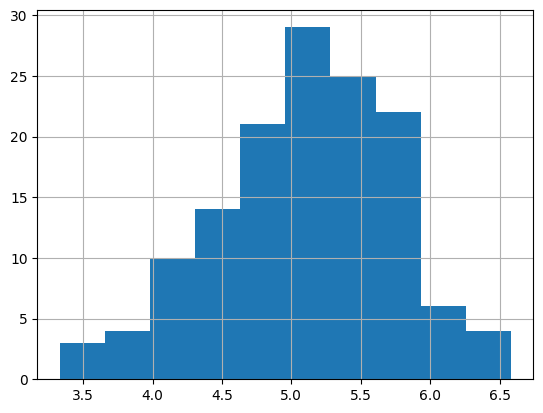

In [78]:
scores_df['Overall'].hist()

<Axes: >

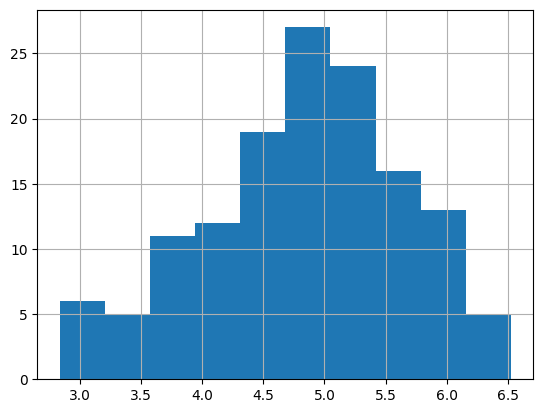

In [79]:
scores_df['Excited'].hist()

In [80]:
pros_features.shape

(690, 36)

In [10]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import re
import torch

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [83]:

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

predefined_questions = [
    ["Please tell me about yourself.", "Tell me a little bit more about your background"],
    ["Tell me about a time when you demonstrated leadership."],
    ["Tell me about a time when you were working on a team and faced a challenge. How did you overcome the problem?"],
    [
        "What is one of your weaknesses and how do you plan to overcome it?",
        "If you were given an option to change one thing about yourself, what would that be?"
    ],
    ["Why do you think we should hire you?", "Why do you think you should get into medical school?"]
]

# Precompute embeddings for predefined question variations
model = SentenceTransformer('all-MiniLM-L6-v2')
predefined_embeddings = [model.encode(variations) for variations in predefined_questions]
question_ids = ["Q1", "Q2", "Q3", "Q4", "Q5"]

In [84]:


def process_transcript(transcript, predefined_embeddings, model, question_ids):
    """
    Processes a single transcript and maps questions with variations, grouping answers accordingly.

    Parameters:
        transcript (str): The text of the interview transcript.
        predefined_embeddings (list): Precomputed embeddings for predefined question variations.
        model (SentenceTransformer): Pre-trained sentence transformer model.
        question_ids (list): Identifiers for predefined questions.

    Returns:
        dict: A mapping of question IDs to their respective answers.
    """
    # Split transcript into interviewer and interviewee parts
    lines = []
    for part in transcript.split('|'):
        if part.startswith("Interviewer: "):
            lines.append(("Interviewer", part.replace("Interviewer: ", "", 1).strip()))
        elif part.startswith("Interviewee: "):
            lines.append(("Interviewee", part.replace("Interviewee: ", "", 1).strip()))
        elif lines:  # Handle continuation of the last line
            last_role, last_text = lines.pop()
            lines.append((last_role, f"{last_text} {part.strip()}"))

    # Extract Interviewer's questions
    conversation_questions = [text for role, text in lines if role == "Interviewer"]

    # Generate embeddings for conversation questions
    conversation_embeddings = model.encode(conversation_questions)

    # Define a similarity threshold
    threshold = 0.40

    # Map questions to predefined questions
    mapped_questions = []
    for i, convo_question in enumerate(conversation_questions):
        max_similarity = 0
        mapped_id = None
        for idx, variations in enumerate(predefined_embeddings):
            similarities = cosine_similarity([conversation_embeddings[i]], variations).flatten()
            max_idx_similarity = similarities.max()
            if max_idx_similarity > max_similarity and max_idx_similarity > threshold:
                max_similarity = max_idx_similarity
                mapped_id = question_ids[idx]
        if mapped_id:
            mapped_questions.append((mapped_id, convo_question))

    # Group answers based on mapped questions
    answers = {qid: [] for qid in question_ids}  # Initialize answers dictionary
    current_question = None
    for role, text in lines:
        if role == "Interviewer" and mapped_questions:
            # Update current question based on mapped questions
            for qid, question_text in mapped_questions:
                if question_text == text:
                    current_question = qid
                    break
        elif role == "Interviewee" and current_question:
            # Append answers to the current question
            answers[current_question].append(text)

    # Combine answers into single strings per question
    for qid in answers:
        answers[qid] = " ".join(answers[qid]).strip() if answers[qid] else None

    # Filter out unmapped questions
    return {qid: answer for qid, answer in answers.items() if answer}

# Process transcript
transcripts['answers'] = transcripts['text'].apply(lambda transcript: process_transcript(transcript, predefined_embeddings, model, question_ids))


In [85]:
df_p = pd.json_normalize(transcripts['answers'])
df_p.columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
df_p = pd.concat([transcripts['id'], df_p], axis=1)
df_p['Q1'] = df_p['Q1'].fillna('')
df_p.head()

,id,Q1,Q2,Q3,Q4,Q5
0,p1,ok uhm so have you looked at my resume or sh...,Ok uhm one of the things we have to do for C...,Ahh I guess the easiest team project I just I...,Uhmmm. I would say for this job ah Im a litt...,Ah Im very interested in the subject of comp...
1,p10,Okay um I'm a Junior here at MIT um I'm st...,Um okay so uh one of the projects that I'v...,Okay um so another another thing that I sp...,Okay um so one of my I think definitely sin...,Okay um I um I mean I think I don't know...
2,p11,Uhh I’m a junior at MIT uhh I’m double major...,Umm so I think this past year my biggest pri...,Umm so I guess this past semester actually I...,Umm so I think one of my weaknesses is public...,Uhh I think my different leadership positions...
3,p12,Ok so I'm a Junior at MIT majoring in Mechan...,Yeah ok. So um in high school I was a life ...,Ok ummm not going to use the lifeguard exampl...,Ok ummm I have a really bad habit of trying t...,Ummmm I think you should hire me because your ...
4,p13,Ok umm I'm currently a junior at M.I.T. stud...,Umm in high school I was part of the school o...,Umm this past summer I worked in Spain. Umm ...,umm well one thing right now is that I can g...,Well I have the I have the quantitative and ...


In [86]:
import re
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.lower()

In [87]:
df_p['Q1'] = df_p['Q1'].apply(clean_text)
df_p['Q2'] = df_p['Q2'].apply(clean_text)
df_p['Q3'] = df_p['Q3'].apply(clean_text)
df_p['Q4'] = df_p['Q4'].apply(clean_text)
df_p['Q5'] = df_p['Q5'].apply(clean_text)

In [88]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

In [89]:
def compute_vocabulary_metrics(answer):
    words = answer.split()
    ttr = len(set(words)) / len(words) if len(words) > 0 else 0
    return ttr

for question in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    df_p[f'{question}_ttr'] = df_p[question].apply(lambda x: pd.Series(compute_vocabulary_metrics(x)))

ttr_columns = [f'{question}_ttr' for question in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
df_p[ttr_columns] = scaler.fit_transform(df_p[ttr_columns])

In [90]:
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_cohesion(answer):
    sentences = answer.split('. ')
    if len(sentences) < 2:
        return 0

    embeddings = model.encode(sentences)
    similarities = [
        cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0]
        for i in range(len(embeddings) - 1)
    ]
    return np.mean(similarities)

for question in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    df_p[f'{question}_cohesion'] = df_p[question].apply(compute_cohesion)

cohesion_columns = [f'{question}_cohesion' for question in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
df_p[cohesion_columns] = scaler.fit_transform(df_p[cohesion_columns])

In [109]:
def count_filler_words(answer):
    filler_words = ["uhm", "uh","uhh","ah", "er", "hmm", "um", "mmm", "ummm", "ummmm",
                 "like", "so", "actually", "basically", "well", "okay", "right"]

    words = answer.lower().split()
    filler_count = sum(words.count(word) for word in filler_words)
    return filler_count / len(words) if len(words) > 0 else 0  # Normalize by total words

# Apply to each question column
for question in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    df_p[f'{question}_filler_ratio'] = df_p[question].apply(count_filler_words)

filler_ratio_columns = [f'{question}_filler_ratio' for question in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
df_p[filler_ratio_columns] = scaler.fit_transform(df_p[filler_ratio_columns])

In [91]:
# !pip install vaderSentiment
import nltk
nltk.download('words')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [92]:
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

# Define a function to calculate average sentiment
def calculate_average_sentiment(text):
    # Split the text into sentences
    sentences = sent_tokenize(text)

    # Calculate sentiment for each sentence
    sentiments = [sent.polarity_scores(sentence)['compound'] for sentence in sentences]

    # Return the average sentiment
    return round(sum(sentiments) / len(sentiments), 2) if sentiments else 0.0

# Apply the function to each column and create new sentiment columns
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
    sentiment_column = f"{q}_sentiment"
    df_p[sentiment_column] = df_p[q].apply(calculate_average_sentiment)

sentiment_columns = [f"{q}_sentiment" for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
df_p[sentiment_columns] = scaler.fit_transform(df_p[sentiment_columns])

In [93]:
import spacy
from collections import Counter

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")


In [94]:
df_p['combined_text'] = df_p[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].apply(lambda x: ' '.join(x), axis=1)

In [95]:
def get_entity_counts(text):
    doc = nlp(text)
    entity_types = [ent.label_ for ent in doc.ents]
    return dict(Counter(entity_types))

In [96]:
# for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
#   df_p[f'{q}_entity_counts'] = df_p[f'{q}'].apply(get_entity_counts)

In [97]:
def entity_diversity(text):

    doc = nlp(text)
    entity_types = [ent.label_ for ent in doc.ents]
    entity_counts = dict(Counter(entity_types))
    total_entities = sum(entity_counts.values())

    unique_entities = len(entity_counts)
    return unique_entities / total_entities if total_entities > 0 else 0

In [98]:
for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']:
  df_p[f'{q}_entity_diversity'] = df_p[f'{q}'].apply(entity_diversity)

entity_diversity_columns = [f'{q}_entity_diversity' for q in ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']]
df_p[entity_diversity_columns] = scaler.fit_transform(df_p[entity_diversity_columns])

In [110]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load spaCy's pre-trained model
nlp = spacy.load("en_core_web_sm")

# Example function to extract entities from text
def extract_entities(text):
    doc = nlp(text)
    entity_counts = {}

    # Loop over the named entities in the text
    for ent in doc.ents:
        if ent.label_ not in entity_counts:
            entity_counts[ent.label_] = 1
        else:
            entity_counts[ent.label_] += 1

    return entity_counts

# Combine text from Q1 to Q5 and extract entities for each interview row
df_p['combined_text'] = df_p[['Q1', 'Q2', 'Q3', 'Q4', 'Q5']].apply(lambda x: ' '.join(x), axis=1)

# Extract entities from the combined text
df_p['entity_counts'] = df_p['combined_text'].apply(extract_entities)

# Create a list of strings that represent each document (with entities as terms)
entity_strings = []
for entity_count in df_p['entity_counts']:
    entity_string = " ".join([f"{k}" for k, v in entity_count.items() for _ in range(v)])
    entity_strings.append(entity_string)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Apply TF-IDF Vectorizer to entity strings
tfidf_matrix = tfidf_vectorizer.fit_transform(entity_strings)

# Convert TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

scaled_tfidf_df = scaler.fit_transform(tfidf_df)

# Convert the scaled NumPy array back into a DataFrame with the same column names
scaled_tfidf_df = pd.DataFrame(scaled_tfidf_df, columns=tfidf_df.columns)

# Combine the scaled TF-IDF values with the original DataFrame (df_p)
df_f = pd.concat([df_p, scaled_tfidf_df], axis=1)


In [101]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
import numpy as np

# Load pre-trained Tiny BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-tiny')
model = BertModel.from_pretrained('prajjwal1/bert-tiny')

def get_tiny_bert_embeddings(text):
    """
    Extract Tiny BERT embeddings for a given text.
    """
    # Tokenize and pad/truncate the input text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)

    # Get embeddings from Tiny BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Average token embeddings to get a single vector for the text
    return outputs.last_hidden_state.mean(dim=1)  # Shape: (1, hidden_size)

def normalize_embeddings(embedding):
    """
    Normalize the embedding vector using L2 normalization.
    """
    norm = np.linalg.norm(embedding)
    return embedding / norm if norm > 0 else embedding

def compute_average_embeddings_all_questions(df, question_columns):
    """
    Compute Tiny BERT embeddings for specified columns in a dataframe,
    average embeddings across all question columns, normalize them,
    and add as new columns.
    """
    all_embeddings = []  # To store final averaged embeddings for each row

    for index, row in df[question_columns].iterrows():
        question_embeddings = []  # To store embeddings for Q1, Q2, ..., Q5 for a single row

        # Compute embeddings for each question in the row
        for col in question_columns:
            embedding = get_tiny_bert_embeddings(row[col]).squeeze(0).numpy()  # Shape: (hidden_size,)
            question_embeddings.append(embedding)

        # Compute the mean of all question embeddings
        mean_embedding = np.mean(question_embeddings, axis=0)

        # Normalize the mean embedding
        normalized_embedding = normalize_embeddings(mean_embedding)
        all_embeddings.append(normalized_embedding)

    # Add normalized embeddings as new columns
    embedding_dim = len(all_embeddings[0])  # Tiny BERT has hidden size of 128
    df[[f"emb_{i}" for i in range(embedding_dim)]] = pd.DataFrame(all_embeddings)

    return df

# Specify question columns (Q1 to Q5)
question_columns = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

# Compute and add normalized averaged embeddings
df_f = compute_average_embeddings_all_questions(df_f, question_columns)


<ipython-input-101-730584caaaef>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"emb_{i}" for i in range(embedding_dim)]] = pd.DataFrame(all_embeddings)
<ipython-input-101-730584caaaef>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f"emb_{i}" for i in range(embedding_dim)]] = pd.DataFrame(all_embeddings)
<ipython-input-101-730584caaaef>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [112]:
cols_to_drop = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'entity_counts', 'combined_text']

df_features = df_f.drop(cols_to_drop, axis=1)
df_features = df_features.rename(columns={'id': 'Participant'})

In [116]:
df_joined = pd.merge(df_features, scores_df, on='Participant', how='left')

In [117]:
df_joined.head(2)

,Participant,Q1_ttr,Q2_ttr,Q3_ttr,Q4_ttr,Q5_ttr,Q1_cohesion,Q2_cohesion,Q3_cohesion,Q4_cohesion,...,norp,ordinal,org,percent,person,product,quantity,time,Overall,Excited
0,p1,0.656627,0.463439,0.593346,0.812187,0.612543,0.477273,0.887008,0.12947,0.294070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.297316,5.043890
1,p10,0.666667,0.000000,0.207376,0.346230,0.053123,0.165720,0.742648,0.49028,0.487739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.725115,4.383947


In [118]:
from sklearn.feature_selection import mutual_info_regression

X = df_joined.drop(columns=['Participant', 'Overall', 'Excited'])
y_outcome = df_joined['Overall']
y_excitement = df_joined['Excited']

# Compute mutual information scores for each target
mi_outcome = mutual_info_regression(X, y_outcome, random_state=42)
mi_excitement = mutual_info_regression(X, y_excitement, random_state=42)

# Create a dataframe for feature importance
mi_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI_Outcome': mi_outcome,
    'MI_Excitement': mi_excitement
})

# Rank features by mutual information for both targets
mi_scores = mi_scores.sort_values(by=['MI_Outcome', 'MI_Excitement'], ascending=False)

# Select top k features
k = 10  # Number of features to select
top_10k_outcome = mi_scores.nlargest(k, 'MI_Outcome')
top_10k_excitement = mi_scores.nlargest(k, 'MI_Excitement')


k = 50
top_50k_outcome = mi_scores.nlargest(k, 'MI_Outcome')
top_50k_excitement = mi_scores.nlargest(k, 'MI_Excitement')

k = 100
top_100k_outcome = mi_scores.nlargest(k, 'MI_Outcome')
top_100k_excitement = mi_scores.nlargest(k, 'MI_Excitement')

print("Top Features for Outcome:")
print(top_10k_outcome)

print("\nTop Features for Excitement Level:")
print(top_10k_outcome)

Top Features for Outcome:
                Feature  MI_Outcome  MI_Excitement
8           Q4_cohesion    0.130151       0.030858
3                Q4_ttr    0.120267       0.017315
22      Q3_filler_ratio    0.088729       0.000000
14         Q5_sentiment    0.074837       0.021548
11         Q2_sentiment    0.067300       0.042331
15  Q1_entity_diversity    0.066175       0.000000
37               person    0.047771       0.000000
31                  loc    0.027111       0.011831
28                  gpe    0.015686       0.000000
0                Q1_ttr    0.013052       0.085158

Top Features for Excitement Level:
                Feature  MI_Outcome  MI_Excitement
8           Q4_cohesion    0.130151       0.030858
3                Q4_ttr    0.120267       0.017315
22      Q3_filler_ratio    0.088729       0.000000
14         Q5_sentiment    0.074837       0.021548
11         Q2_sentiment    0.067300       0.042331
15  Q1_entity_diversity    0.066175       0.000000
37               per

In [119]:
non_embedding_features = df_joined.drop(columns=[col for col in df_joined.columns if col.startswith('emb_') or col == 'Participant'])

correlations = non_embedding_features.corr()

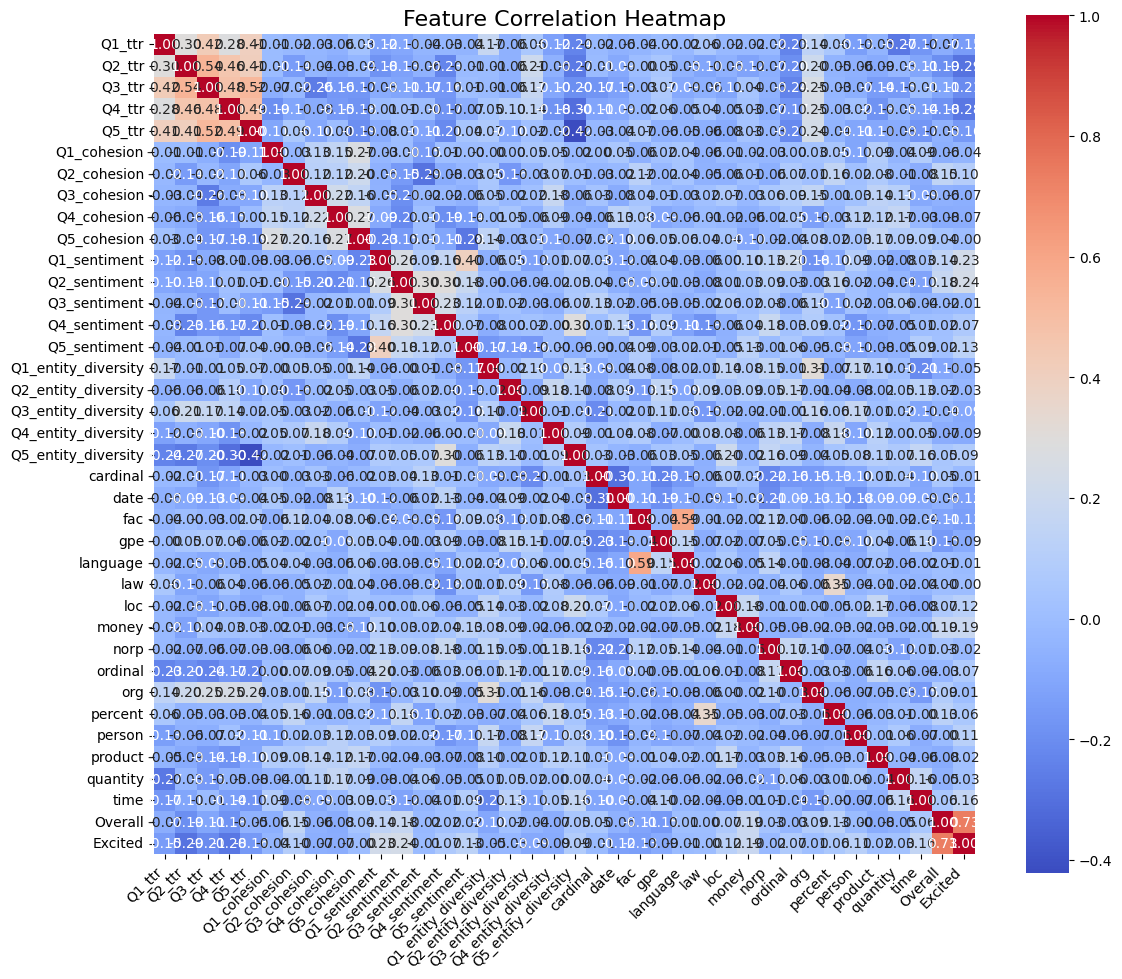

In [108]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()